In [82]:
%pip install kagglehub scikit-learn scikit-optimize sklearn-genetic-opt pandas matplotlib seaborn -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\projetos\kaua\Trabalho_Topicos_9\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from matplotlib.patches import Patch
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform
from time import perf_counter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Integer as GInteger, Categorical as GCategorical

## Instalação do Dataset

In [84]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
csv_path = os.path.join(path, "diabetes.csv")
df = pd.read_csv(csv_path)

In [85]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [86]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Preparação dos Dados

In [87]:
X,y = df.drop('Outcome', axis=1), df['Outcome']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((537, 8), (231, 8), (537,), (231,))

## Modelos

In [90]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": "f1",
    "roc_auc": "roc_auc",
    "kappa": make_scorer(cohen_kappa_score),
}
primary_metric = "f1"

def evaluate_on_test(estimator, X_t, y_t):
    y_pred = estimator.predict(X_t)
    y_proba = estimator.predict_proba(X_t)[:, 1] if hasattr(estimator, "predict_proba") else None
    
    metrics = {
        "accuracy": accuracy_score(y_t, y_pred),
        "precision": precision_score(y_t, y_pred, zero_division=0),
        "recall": recall_score(y_t, y_pred, zero_division=0),
        "f1": f1_score(y_t, y_pred),
        "kappa": cohen_kappa_score(y_t, y_pred),
        "roc_auc": roc_auc_score(y_t, y_proba) if y_proba is not None else np.nan
    }
    return metrics

def summarize_cv(searcher):
    idx = searcher.best_index_
    results = {}
    
    for metric in scoring.keys():
        mean_key = f"mean_test_{metric}"
        std_key = f"std_test_{metric}"
        if mean_key in searcher.cv_results_:
            results[f"cv_{metric}_mean"] = searcher.cv_results_[mean_key][idx]
            results[f"cv_{metric}_std"] = searcher.cv_results_[std_key][idx]
    
    return results

def create_pipeline(classifier):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", classifier)
    ])

svm_params = {
    "GridSearch": [
        {"clf__kernel": ["linear"], "clf__C": [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3], "clf__class_weight": [None, "balanced"]},
        {"clf__kernel": ["rbf"], "clf__C": [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3], "clf__gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1.0], "clf__class_weight": [None, "balanced"]},
    ],
    "RandomizedSearch": {
        "clf__kernel": ["linear", "rbf"],
        "clf__C": loguniform(1e-3, 1e3),
        "clf__gamma": loguniform(1e-4, 1.0),
        "clf__class_weight": [None, "balanced"],
    },
    "BayesSearchCV": {
        "clf__kernel": Categorical(["linear", "rbf"]),
        "clf__C": Real(1e-3, 1e3, prior="log-uniform"),
        "clf__gamma": Real(1e-4, 1.0, prior="log-uniform"),
        "clf__class_weight": Categorical([None, "balanced"]),
    },
    "GeneticSearchCV": {
        "clf__kernel": GCategorical(["linear", "rbf"]),
        "clf__C": Continuous(1e-3, 1e3, distribution="log-uniform"),
        "clf__gamma": Continuous(1e-4, 1.0, distribution="log-uniform"),
        "clf__class_weight": GCategorical([None, "balanced"]),
    }
}

mlp_params = {
    "GridSearch": {
        "clf__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64), (256, 128)],
        "clf__activation": ["relu", "tanh"],
        "clf__solver": ["adam", "lbfgs"],
        "clf__alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
        "clf__learning_rate_init": [1e-4, 1e-3, 1e-2],
        "clf__max_iter": [300, 600],
        "clf__early_stopping": [True],
    },
    "RandomizedSearch": {
        "clf__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64), (256, 128)],
        "clf__activation": ["relu", "tanh"],
        "clf__solver": ["adam", "lbfgs"],
        "clf__alpha": loguniform(1e-6, 1e-2),
        "clf__learning_rate_init": loguniform(1e-4, 1e-2),
        "clf__max_iter": [300, 600],
        "clf__early_stopping": [True],
    },
    "BayesSearchCV": {
        "clf__activation": Categorical(["relu", "tanh"]),
        "clf__solver": Categorical(["adam", "lbfgs"]),
        "clf__alpha": Real(1e-6, 1e-2, prior="log-uniform"),
        "clf__learning_rate_init": Real(1e-4, 1e-2, prior="log-uniform"),
        "clf__max_iter": Integer(300, 600),
        "clf__early_stopping": Categorical([True]),
    },
    "GeneticSearchCV": {
        "clf__hidden_layer_sizes": GCategorical([(64,), (128,), (64, 32), (128, 64), (256, 128)]),
        "clf__activation": GCategorical(["relu", "tanh"]),
        "clf__solver": GCategorical(["adam", "lbfgs"]),
        "clf__alpha": Continuous(1e-6, 1e-2, distribution="log-uniform"),
        "clf__learning_rate_init": Continuous(1e-4, 1e-2, distribution="log-uniform"),
        "clf__max_iter": GInteger(300, 600),
        "clf__early_stopping": GCategorical([True]),
    }
}

def run_optimization(model_name, strategy_name, pipeline, param_space):
    t0 = perf_counter()
    
    if strategy_name == "BayesSearchCV" and model_name == "MLP":
        pipeline.set_params(clf__hidden_layer_sizes=(128, 64))

    if strategy_name == "GridSearch":
        searcher = GridSearchCV(pipeline, param_space, cv=cv, scoring=scoring, refit=primary_metric, n_jobs=-1, verbose=0)
    elif strategy_name == "RandomizedSearch":
        searcher = RandomizedSearchCV(pipeline, param_space, n_iter=20, cv=cv, scoring=scoring, refit=primary_metric, n_jobs=-1, random_state=42, verbose=0)
    elif strategy_name == "BayesSearchCV":
        searcher = BayesSearchCV(pipeline, param_space, n_iter=30, cv=cv, scoring=scoring, refit=primary_metric, n_jobs=-1, random_state=42, verbose=0)
    else:  # GeneticSearchCV
        searcher = GASearchCV(pipeline, cv=cv, scoring=make_scorer(f1_score), param_grid=param_space, n_jobs=-1, generations=20, population_size=30, tournament_size=3, elitism=True, mutation_probability=0.1, crossover_probability=0.8, verbose=False)
    
    searcher.fit(X_train, y_train)
    tempo = perf_counter() - t0

    result = {
        "model": model_name,
        "strategy": strategy_name,
        "time_s": tempo,
        "best_params": str(searcher.best_params_)
    }
    result.update(summarize_cv(searcher))
    result.update({f"test_{k}": v for k, v in evaluate_on_test(searcher.best_estimator_, X_test, y_test).items()})
    
    return result

results = []

for model_name, classifier, params in [
    ("SVM", SVC(probability=True, random_state=42), svm_params),
    ("MLP", MLPClassifier(random_state=42), mlp_params)
]:
    for strategy in ["GridSearch", "RandomizedSearch", "BayesSearchCV", "GeneticSearchCV"]:
        pipeline = create_pipeline(classifier)
        result = run_optimization(model_name, strategy, pipeline, params[strategy])
        results.append(result)

df_results = pd.DataFrame(results)
df_results

Modelo: SVM | Estratégia: GridSearch
Concluído em 13.26s
Modelo: SVM | Estratégia: RandomizedSearch
Concluído em 13.26s
Modelo: SVM | Estratégia: RandomizedSearch
Concluído em 0.54s
Modelo: SVM | Estratégia: BayesSearchCV
Concluído em 0.54s
Modelo: SVM | Estratégia: BayesSearchCV
Concluído em 34.74s
Modelo: SVM | Estratégia: GeneticSearchCV
Concluído em 34.74s
Modelo: SVM | Estratégia: GeneticSearchCV
Concluído em 83.98s
Modelo: MLP | Estratégia: GridSearch
Concluído em 83.98s
Modelo: MLP | Estratégia: GridSearch
Concluído em 76.08s
Modelo: MLP | Estratégia: RandomizedSearch
Concluído em 76.08s
Modelo: MLP | Estratégia: RandomizedSearch
Concluído em 3.22s
Modelo: MLP | Estratégia: BayesSearchCV
Concluído em 3.22s
Modelo: MLP | Estratégia: BayesSearchCV
Concluído em 19.23s
Modelo: MLP | Estratégia: GeneticSearchCV
Concluído em 19.23s
Modelo: MLP | Estratégia: GeneticSearchCV
Concluído em 32.80s
Concluído em 32.80s


,model,strategy,time_s,best_params,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,...,cv_roc_auc_mean,cv_roc_auc_std,cv_kappa_mean,cv_kappa_std,test_accuracy,test_precision,test_recall,test_f1,test_kappa,test_roc_auc
0,SVM,GridSearch,13.260908,"{'clf__C': 100.0, 'clf__class_weight': 'balanc...",0.778349,0.045474,0.669658,0.086032,0.732706,0.056472,...,0.842547,0.041486,0.523703,0.098448,0.705628,0.561224,0.6875,0.617978,0.382499,0.796440
1,SVM,RandomizedSearch,0.544843,"{'clf__C': np.float64(98.77700294007911), 'clf...",0.778349,0.045474,0.669658,0.086032,0.732706,0.056472,...,0.842846,0.041774,0.523703,0.098448,0.705628,0.561224,0.6875,0.617978,0.382499,0.796689
2,SVM,BayesSearchCV,34.743371,"OrderedDict([('clf__C', 5.0405293861834055), (...",0.783956,0.049693,0.674500,0.095695,0.747435,0.071822,...,0.844578,0.042525,0.536620,0.110538,0.701299,0.555556,0.6875,0.614525,0.375162,0.796813
3,SVM,GeneticSearchCV,83.980405,"{'clf__kernel': 'linear', 'clf__C': np.float64...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.709957,0.568421,0.6750,0.617143,0.386442,0.794288
4,MLP,GridSearch,76.083745,"{'clf__activation': 'relu', 'clf__alpha': 0.01...",0.780183,0.041412,0.703848,0.078338,0.639642,0.089152,...,0.840483,0.040481,0.503246,0.099513,0.744589,0.626506,0.6500,0.638037,0.440816,0.798096
5,MLP,RandomizedSearch,3.224962,"{'clf__activation': 'relu', 'clf__alpha': np.f...",0.728141,0.050093,0.619889,0.091342,0.670256,0.114834,...,0.765836,0.034307,0.423562,0.086123,0.679654,0.531915,0.6250,0.574713,0.320426,0.688245
6,MLP,BayesSearchCV,19.231599,"OrderedDict([('clf__activation', 'tanh'), ('cl...",0.761578,0.050211,0.663143,0.101162,0.676270,0.052544,...,0.809770,0.047740,0.482304,0.104240,0.666667,0.516854,0.5750,0.544379,0.282753,0.743129
7,MLP,GeneticSearchCV,32.799654,"{'clf__hidden_layer_sizes': (128, 64), 'clf__a...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.666667,0.516484,0.5875,0.549708,0.286837,0.730298


## Análise dos Resultados

In [113]:
def format_metric(mean, std):
    return f"{mean:.4f} ± {std:.4f}"

presentation_df = df_results.copy()
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'kappa']
output_md = "# RESULTADOS COMPLETOS: Validação Cruzada (CV) e Teste\n\n"

for idx, row in presentation_df.iterrows():
    output_md += f"## Modelo: {row['model']} | Estratégia: {row['strategy']}\n\n"
    output_md += f"**Tempo de execução:** {row['time_s']:.2f}s\n\n"
    output_md += f"| Métrica | CV (Média ± DP) | Teste |\n"
    output_md += f"|---------|-----------------|-------|\n"
    
    for metric in metrics:
        cv_mean_key = f'cv_{metric}_mean'
        cv_std_key = f'cv_{metric}_std'
        test_key = f'test_{metric}'
        
        if cv_mean_key in row and test_key in row:
            cv_value = format_metric(row[cv_mean_key], row[cv_std_key])
            test_value = f"{row[test_key]:.4f}"
            output_md += f"| {metric.upper()} | {cv_value} | {test_value} |\n"
    
    output_md += f"\n"

display(Markdown(output_md))

# RESULTADOS COMPLETOS: Validação Cruzada (CV) e Teste

## Modelo: SVM | Estratégia: GridSearch

**Tempo de execução:** 13.26s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7783 ± 0.0455 | 0.7056 |
| PRECISION | 0.6697 ± 0.0860 | 0.5612 |
| RECALL | 0.7327 ± 0.0565 | 0.6875 |
| F1 | 0.6980 ± 0.0649 | 0.6180 |
| ROC_AUC | 0.8425 ± 0.0415 | 0.7964 |
| KAPPA | 0.5237 ± 0.0984 | 0.3825 |

## Modelo: SVM | Estratégia: RandomizedSearch

**Tempo de execução:** 0.54s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7783 ± 0.0455 | 0.7056 |
| PRECISION | 0.6697 ± 0.0860 | 0.5612 |
| RECALL | 0.7327 ± 0.0565 | 0.6875 |
| F1 | 0.6980 ± 0.0649 | 0.6180 |
| ROC_AUC | 0.8428 ± 0.0418 | 0.7967 |
| KAPPA | 0.5237 ± 0.0984 | 0.3825 |

## Modelo: SVM | Estratégia: BayesSearchCV

**Tempo de execução:** 34.74s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7840 ± 0.0497 | 0.7013 |
| PRECISION | 0.6745 ± 0.0957 | 0.5556 |
| RECALL | 0.7474 ± 0.0718 | 0.6875 |
| F1 | 0.7070 ± 0.0750 | 0.6145 |
| ROC_AUC | 0.8446 ± 0.0425 | 0.7968 |
| KAPPA | 0.5366 ± 0.1105 | 0.3752 |

## Modelo: SVM | Estratégia: GeneticSearchCV

**Tempo de execução:** 83.98s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | nan ± nan | 0.7100 |
| PRECISION | nan ± nan | 0.5684 |
| RECALL | nan ± nan | 0.6750 |
| F1 | nan ± nan | 0.6171 |
| ROC_AUC | nan ± nan | 0.7943 |
| KAPPA | nan ± nan | 0.3864 |

## Modelo: MLP | Estratégia: GridSearch

**Tempo de execução:** 76.08s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7802 ± 0.0414 | 0.7446 |
| PRECISION | 0.7038 ± 0.0783 | 0.6265 |
| RECALL | 0.6396 ± 0.0892 | 0.6500 |
| F1 | 0.6678 ± 0.0759 | 0.6380 |
| ROC_AUC | 0.8405 ± 0.0405 | 0.7981 |
| KAPPA | 0.5032 ± 0.0995 | 0.4408 |

## Modelo: MLP | Estratégia: RandomizedSearch

**Tempo de execução:** 3.22s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7281 ± 0.0501 | 0.6797 |
| PRECISION | 0.6199 ± 0.0913 | 0.5319 |
| RECALL | 0.6703 ± 0.1148 | 0.6250 |
| F1 | 0.6312 ± 0.0555 | 0.5747 |
| ROC_AUC | 0.7658 ± 0.0343 | 0.6882 |
| KAPPA | 0.4236 ± 0.0861 | 0.3204 |

## Modelo: MLP | Estratégia: BayesSearchCV

**Tempo de execução:** 19.23s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | 0.7616 ± 0.0502 | 0.6667 |
| PRECISION | 0.6631 ± 0.1012 | 0.5169 |
| RECALL | 0.6763 ± 0.0525 | 0.5750 |
| F1 | 0.6658 ± 0.0661 | 0.5444 |
| ROC_AUC | 0.8098 ± 0.0477 | 0.7431 |
| KAPPA | 0.4823 ± 0.1042 | 0.2828 |

## Modelo: MLP | Estratégia: GeneticSearchCV

**Tempo de execução:** 32.80s

| Métrica | CV (Média ± DP) | Teste |
|---------|-----------------|-------|
| ACCURACY | nan ± nan | 0.6667 |
| PRECISION | nan ± nan | 0.5165 |
| RECALL | nan ± nan | 0.5875 |
| F1 | nan ± nan | 0.5497 |
| ROC_AUC | nan ± nan | 0.7303 |
| KAPPA | nan ± nan | 0.2868 |



### Análise Comparativa por Modelo

In [115]:
output_md = "# COMPARAÇÃO DE DESEMPENHO POR MODELO\n\n"

for model in df_results['model'].unique():
    output_md += f"\n\n## MODELO: {model}\n\n"
    
    model_data = df_results[df_results['model'] == model].copy()
    
    best_cv = model_data.loc[model_data['cv_f1_mean'].idxmax()]
    output_md += f"### Melhor estratégia por F1 (Validação Cruzada)\n\n"
    output_md += f"- **Estratégia:** {best_cv['strategy']}\n"
    output_md += f"- **F1 (CV):** {best_cv['cv_f1_mean']:.4f} ± {best_cv['cv_f1_std']:.4f}\n"
    output_md += f"- **F1 (Teste):** {best_cv['test_f1']:.4f}\n"
    output_md += f"- **Tempo:** {best_cv['time_s']:.2f}s\n\n"
    
    best_test = model_data.loc[model_data['test_f1'].idxmax()]
    output_md += f"### Melhor estratégia por F1 (Teste)\n\n"
    output_md += f"- **Estratégia:** {best_test['strategy']}\n"
    output_md += f"- **F1 (CV):** {best_test['cv_f1_mean']:.4f} ± {best_test['cv_f1_std']:.4f}\n"
    output_md += f"- **F1 (Teste):** {best_test['test_f1']:.4f}\n"
    output_md += f"- **Tempo:** {best_test['time_s']:.2f}s\n\n"
    
    fastest = model_data.loc[model_data['time_s'].idxmin()]
    output_md += f"### Estratégia mais rápida\n\n"
    output_md += f"- **Estratégia:** {fastest['strategy']}\n"
    output_md += f"- **F1 (Teste):** {fastest['test_f1']:.4f}\n"
    output_md += f"- **Tempo:** {fastest['time_s']:.2f}s\n\n"
    
    output_md += f"### Resumo de todas as estratégias\n\n"
    output_md += f"| Estratégia | F1 (CV) | F1 (Teste) | Tempo (s) |\n"
    output_md += f"|------------|---------|------------|----------|\n"
    for _, row in model_data.iterrows():
        cv_f1 = f"{row['cv_f1_mean']:.4f} ± {row['cv_f1_std']:.4f}"
        output_md += f"| {row['strategy']} | {cv_f1} | {row['test_f1']:.4f} | {row['time_s']:.2f} |\n"
    
    output_md += f"\n"

display(Markdown(output_md))

# COMPARAÇÃO DE DESEMPENHO POR MODELO



## MODELO: SVM

### Melhor estratégia por F1 (Validação Cruzada)

- **Estratégia:** BayesSearchCV
- **F1 (CV):** 0.7070 ± 0.0750
- **F1 (Teste):** 0.6145
- **Tempo:** 34.74s

### Melhor estratégia por F1 (Teste)

- **Estratégia:** GridSearch
- **F1 (CV):** 0.6980 ± 0.0649
- **F1 (Teste):** 0.6180
- **Tempo:** 13.26s

### Estratégia mais rápida

- **Estratégia:** RandomizedSearch
- **F1 (Teste):** 0.6180
- **Tempo:** 0.54s

### Resumo de todas as estratégias

| Estratégia | F1 (CV) | F1 (Teste) | Tempo (s) |
|------------|---------|------------|----------|
| GridSearch | 0.6980 ± 0.0649 | 0.6180 | 13.26 |
| RandomizedSearch | 0.6980 ± 0.0649 | 0.6180 | 0.54 |
| BayesSearchCV | 0.7070 ± 0.0750 | 0.6145 | 34.74 |
| GeneticSearchCV | nan ± nan | 0.6171 | 83.98 |



## MODELO: MLP

### Melhor estratégia por F1 (Validação Cruzada)

- **Estratégia:** GridSearch
- **F1 (CV):** 0.6678 ± 0.0759
- **F1 (Teste):** 0.6380
- **Tempo:** 76.08s

### Melhor estratégia por F1 (Teste)

- **Estratégia:** GridSearch
- **F1 (CV):** 0.6678 ± 0.0759
- **F1 (Teste):** 0.6380
- **Tempo:** 76.08s

### Estratégia mais rápida

- **Estratégia:** RandomizedSearch
- **F1 (Teste):** 0.5747
- **Tempo:** 3.22s

### Resumo de todas as estratégias

| Estratégia | F1 (CV) | F1 (Teste) | Tempo (s) |
|------------|---------|------------|----------|
| GridSearch | 0.6678 ± 0.0759 | 0.6380 | 76.08 |
| RandomizedSearch | 0.6312 ± 0.0555 | 0.5747 | 3.22 |
| BayesSearchCV | 0.6658 ± 0.0661 | 0.5444 | 19.23 |
| GeneticSearchCV | nan ± nan | 0.5497 | 32.80 |



### Análise de Overfitting e Estabilidade

In [117]:
df_results['gap_f1'] = df_results['cv_f1_mean'] - df_results['test_f1']
df_results['cv_coefficient_variation'] = (df_results['cv_f1_std'] / df_results['cv_f1_mean']) * 100

output_md = "# ANÁLISE DE OVERFITTING E ESTABILIDADE\n\n"
output_md += "| Modelo | Estratégia | F1 CV | F1 Teste | Gap | CV (%) | Interpretação |\n"
output_md += "|--------|-----------|--------|----------|-----|--------|---------------|\n"

for _, row in df_results.iterrows():
    gap = row['gap_f1']
    cv_coef = row['cv_coefficient_variation']
    
    # Interpretação do overfitting
    if abs(gap) < 0.02:
        overfitting = "Bom ajuste"
    elif gap > 0.05:
        overfitting = "Overfitting"
    elif gap < -0.05:
        overfitting = "Underfitting"
    else:
        overfitting = "Aceitável"
    
    # Interpretação da estabilidade
    if cv_coef < 5:
        stability = "Muito estável"
    elif cv_coef < 10:
        stability = "Estável"
    else:
        stability = "Instável"
    
    interpretation = f"{overfitting}, {stability}"
    
    output_md += f"| {row['model']} | {row['strategy']} | {row['cv_f1_mean']:.4f} | {row['test_f1']:.4f} | {gap:.4f} | {cv_coef:.2f} | {interpretation} |\n"

output_md += "\n\n\n## RESUMO DA ANÁLISE\n\n"

most_stable = df_results.loc[df_results['cv_coefficient_variation'].idxmin()]
output_md += f"**Configuração mais estável:**\n\n"
output_md += f"- Modelo: {most_stable['model']}\n"
output_md += f"- Estratégia: {most_stable['strategy']}\n"
output_md += f"- Coeficiente de variação: {most_stable['cv_coefficient_variation']:.2f}%\n\n"

best_gen = df_results.loc[df_results['gap_f1'].abs().idxmin()]
output_md += f"**Melhor generalização:**\n\n"
output_md += f"- Modelo: {best_gen['model']}\n"
output_md += f"- Estratégia: {best_gen['strategy']}\n"
output_md += f"- Gap CV-Teste: {best_gen['gap_f1']:.4f}\n\n"

overfit_cases = df_results[df_results['gap_f1'] > 0.05]
if len(overfit_cases) > 0:
    output_md += f"**Casos de possível overfitting:**\n\n"
    for _, row in overfit_cases.iterrows():
        output_md += f"- {row['model']} ({row['strategy']}): Gap = {row['gap_f1']:.4f}\n"
else:
    output_md += f"**Nenhum caso significativo de overfitting detectado**\n"

display(Markdown(output_md))

# ANÁLISE DE OVERFITTING E ESTABILIDADE

| Modelo | Estratégia | F1 CV | F1 Teste | Gap | CV (%) | Interpretação |
|--------|-----------|--------|----------|-----|--------|---------------|
| SVM | GridSearch | 0.6980 | 0.6180 | 0.0801 | 9.30 | Overfitting, Estável |
| SVM | RandomizedSearch | 0.6980 | 0.6180 | 0.0801 | 9.30 | Overfitting, Estável |
| SVM | BayesSearchCV | 0.7070 | 0.6145 | 0.0925 | 10.60 | Overfitting, Instável |
| SVM | GeneticSearchCV | nan | 0.6171 | nan | nan | Aceitável, Instável |
| MLP | GridSearch | 0.6678 | 0.6380 | 0.0298 | 11.37 | Aceitável, Instável |
| MLP | RandomizedSearch | 0.6312 | 0.5747 | 0.0565 | 8.80 | Overfitting, Estável |
| MLP | BayesSearchCV | 0.6658 | 0.5444 | 0.1214 | 9.92 | Overfitting, Estável |
| MLP | GeneticSearchCV | nan | 0.5497 | nan | nan | Aceitável, Instável |



## RESUMO DA ANÁLISE

**Configuração mais estável:**

- Modelo: MLP
- Estratégia: RandomizedSearch
- Coeficiente de variação: 8.80%

**Melhor generalização:**

- Modelo: MLP
- Estratégia: GridSearch
- Gap CV-Teste: 0.0298

**Casos de possível overfitting:**

- SVM (GridSearch): Gap = 0.0801
- SVM (RandomizedSearch): Gap = 0.0801
- SVM (BayesSearchCV): Gap = 0.0925
- MLP (RandomizedSearch): Gap = 0.0565
- MLP (BayesSearchCV): Gap = 0.1214


### Respostas às Questões do Relatório

In [120]:
output_md = "# RESPOSTAS ÀS QUESTÕES DO RELATÓRIO\n\n"
output_md += "## 1. Qual estratégia obteve melhor equilíbrio entre desempenho e custo?\n\n"

df_results['efficiency_score'] = df_results['test_f1'] / (df_results['time_s'] / 60)  # F1 por minuto

best_efficiency = df_results.loc[df_results['efficiency_score'].idxmax()]
output_md += f"**Melhor equilíbrio:** {best_efficiency['model']} - {best_efficiency['strategy']}\n\n"
output_md += f"- F1 (Teste): {best_efficiency['test_f1']:.4f}\n"
output_md += f"- Tempo: {best_efficiency['time_s']:.2f}s ({best_efficiency['time_s']/60:.2f} min)\n"
output_md += f"- Eficiência: {best_efficiency['efficiency_score']:.4f} F1/min\n\n"

output_md += "### Ranking de eficiência\n\n"
output_md += "| Modelo | Estratégia | F1 Teste | Tempo (s) | Eficiência |\n"
output_md += "|--------|-----------|----------|-----------|------------|\n"
for _, row in df_results.sort_values('efficiency_score', ascending=False).iterrows():
    output_md += f"| {row['model']} | {row['strategy']} | {row['test_f1']:.4f} | {row['time_s']:.2f} | {row['efficiency_score']:.4f} |\n"

output_md += "\n\n\n## 2. Qual modelo se beneficiou mais da otimização?\n\n"

for model in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model]
    f1_range = model_data['test_f1'].max() - model_data['test_f1'].min()
    best_strategy = model_data.loc[model_data['test_f1'].idxmax(), 'strategy']
    worst_strategy = model_data.loc[model_data['test_f1'].idxmin(), 'strategy']
    
    output_md += f"### {model}\n\n"
    output_md += f"- Variação de F1: {f1_range:.4f}\n"
    output_md += f"- Melhor: {best_strategy} (F1 = {model_data['test_f1'].max():.4f})\n"
    output_md += f"- Pior: {worst_strategy} (F1 = {model_data['test_f1'].min():.4f})\n"
    output_md += f"- Ganho relativo: {(f1_range / model_data['test_f1'].min() * 100):.2f}%\n\n"

most_benefit_model = df_results.groupby('model')['test_f1'].apply(lambda x: x.max() - x.min()).idxmax()
output_md += f"**Modelo que mais se beneficiou:** {most_benefit_model}\n\n"

output_md += "\n\n## 3. Há overfitting na busca?\n\n"

overfit_analysis = df_results[['model', 'strategy', 'cv_f1_mean', 'test_f1', 'gap_f1']].copy()
overfit_analysis = overfit_analysis.sort_values('gap_f1', ascending=False)

output_md += "| Modelo | Estratégia | F1 CV | F1 Teste | Gap | Status |\n"
output_md += "|--------|-----------|--------|----------|-----|--------|\n"

for _, row in overfit_analysis.iterrows():
    if row['gap_f1'] > 0.05:
        status = "Overfitting"
    elif row['gap_f1'] < -0.05:
        status = "Underfitting"
    elif abs(row['gap_f1']) < 0.02:
        status = "Excelente"
    else:
        status = "Bom"
    
    output_md += f"| {row['model']} | {row['strategy']} | {row['cv_f1_mean']:.4f} | {row['test_f1']:.4f} | {row['gap_f1']:.4f} | {status} |\n"

avg_gap = df_results['gap_f1'].mean()
output_md += f"\n**Gap médio CV-Teste:** {avg_gap:.4f}\n\n"

if avg_gap > 0.05:
    output_md += "Há indícios de overfitting geral no processo de busca.\n"
elif abs(avg_gap) < 0.02:
    output_md += "Não há overfitting significativo - boa generalização.\n"
else:
    output_md += "Overfitting controlado - resultados aceitáveis.\n"

display(Markdown(output_md))

# RESPOSTAS ÀS QUESTÕES DO RELATÓRIO

## 1. Qual estratégia obteve melhor equilíbrio entre desempenho e custo?

**Melhor equilíbrio:** SVM - RandomizedSearch

- F1 (Teste): 0.6180
- Tempo: 0.54s (0.01 min)
- Eficiência: 68.0538 F1/min

### Ranking de eficiência

| Modelo | Estratégia | F1 Teste | Tempo (s) | Eficiência |
|--------|-----------|----------|-----------|------------|
| SVM | RandomizedSearch | 0.6180 | 0.54 | 68.0538 |
| MLP | RandomizedSearch | 0.5747 | 3.22 | 10.6925 |
| SVM | GridSearch | 0.6180 | 13.26 | 2.7961 |
| MLP | BayesSearchCV | 0.5444 | 19.23 | 1.6984 |
| SVM | BayesSearchCV | 0.6145 | 34.74 | 1.0613 |
| MLP | GeneticSearchCV | 0.5497 | 32.80 | 1.0056 |
| MLP | GridSearch | 0.6380 | 76.08 | 0.5032 |
| SVM | GeneticSearchCV | 0.6171 | 83.98 | 0.4409 |



## 2. Qual modelo se beneficiou mais da otimização?

### SVM

- Variação de F1: 0.0035
- Melhor: GridSearch (F1 = 0.6180)
- Pior: BayesSearchCV (F1 = 0.6145)
- Ganho relativo: 0.56%

### MLP

- Variação de F1: 0.0937
- Melhor: GridSearch (F1 = 0.6380)
- Pior: BayesSearchCV (F1 = 0.5444)
- Ganho relativo: 17.20%

**Modelo que mais se beneficiou:** MLP



## 3. Há overfitting na busca?

| Modelo | Estratégia | F1 CV | F1 Teste | Gap | Status |
|--------|-----------|--------|----------|-----|--------|
| MLP | BayesSearchCV | 0.6658 | 0.5444 | 0.1214 | Overfitting |
| SVM | BayesSearchCV | 0.7070 | 0.6145 | 0.0925 | Overfitting |
| SVM | RandomizedSearch | 0.6980 | 0.6180 | 0.0801 | Overfitting |
| SVM | GridSearch | 0.6980 | 0.6180 | 0.0801 | Overfitting |
| MLP | RandomizedSearch | 0.6312 | 0.5747 | 0.0565 | Overfitting |
| MLP | GridSearch | 0.6678 | 0.6380 | 0.0298 | Bom |
| SVM | GeneticSearchCV | nan | 0.6171 | nan | Bom |
| MLP | GeneticSearchCV | nan | 0.5497 | nan | Bom |

**Gap médio CV-Teste:** 0.0767

Há indícios de overfitting geral no processo de busca.


### Visualizações

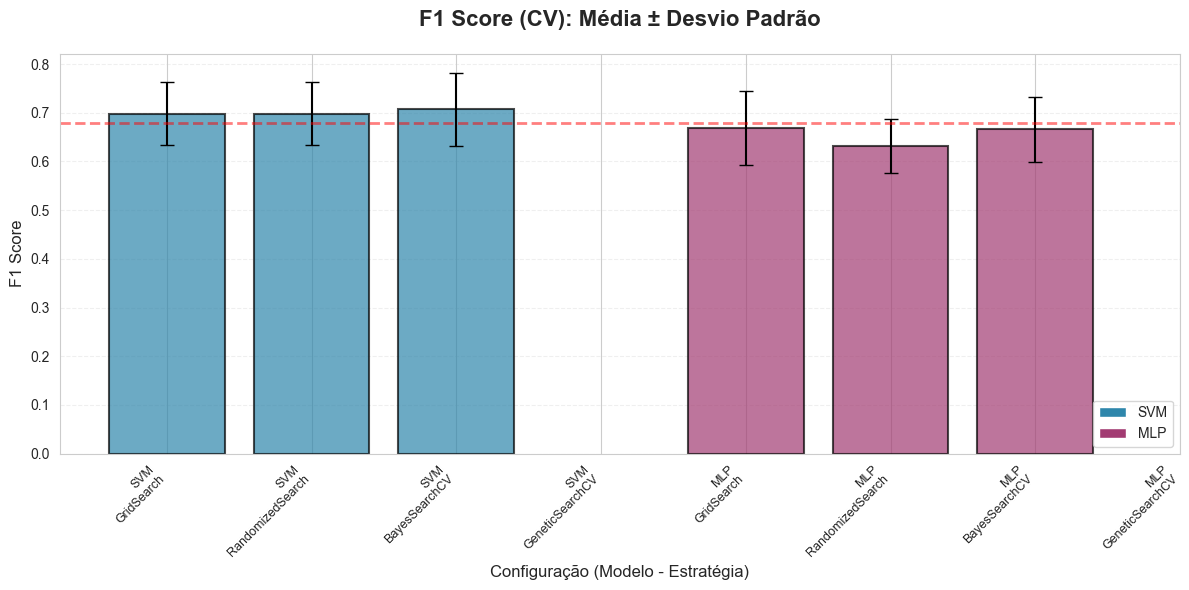

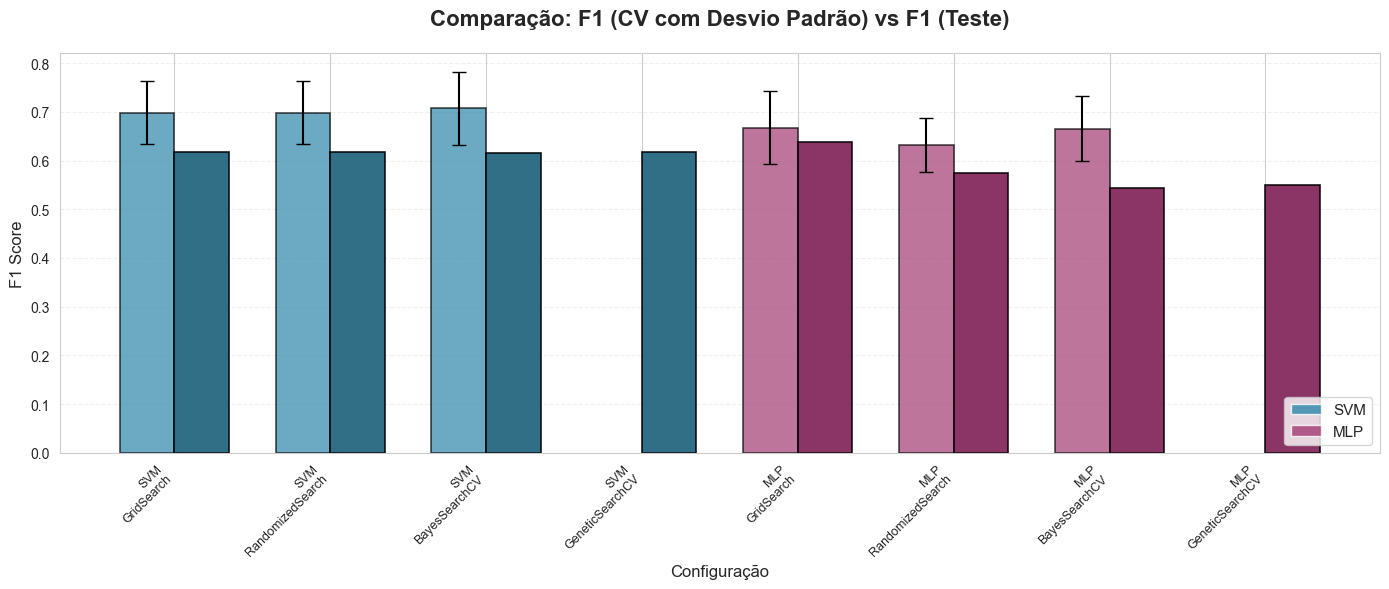

C:\Users\kauas\AppData\Local\Temp\ipykernel_12004\2802032884.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(strategy_data, labels=strategies, patch_artist=True,


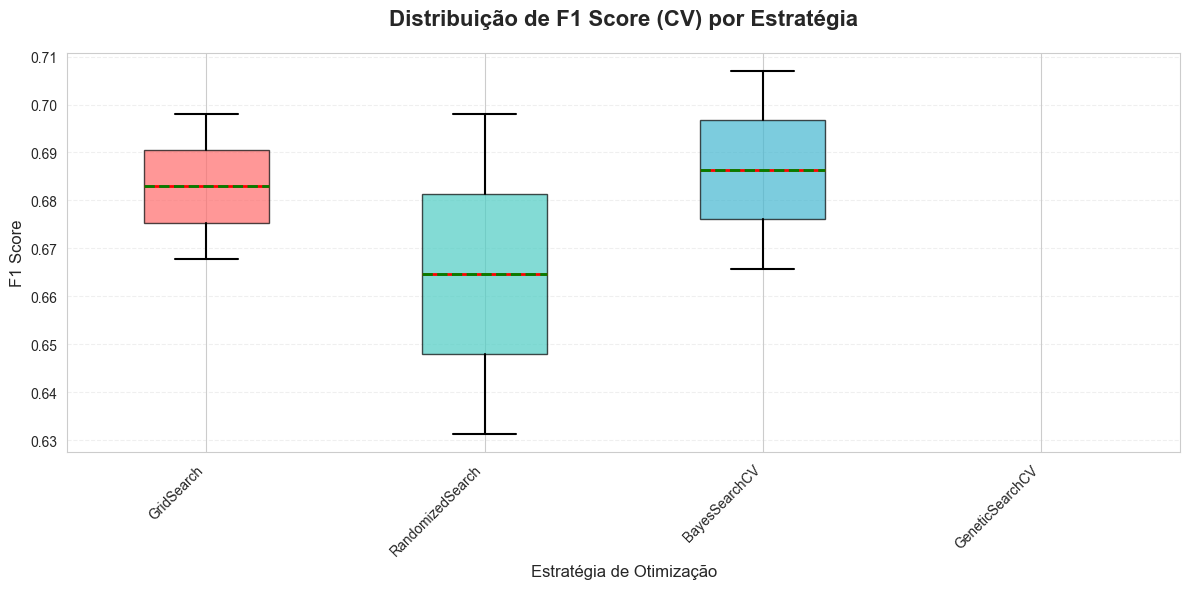

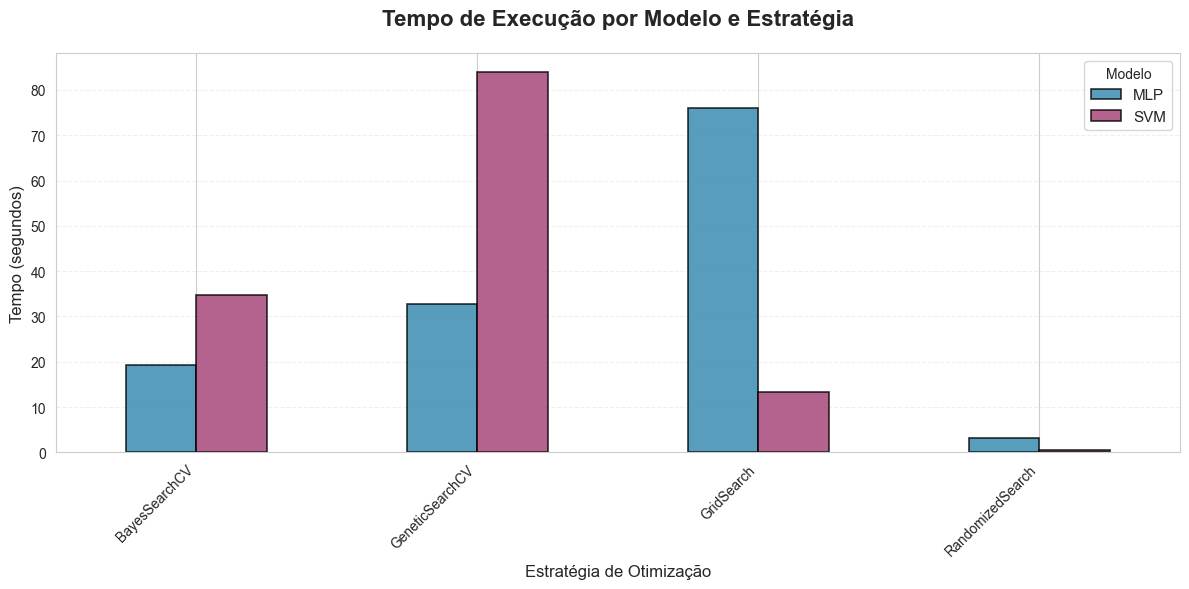

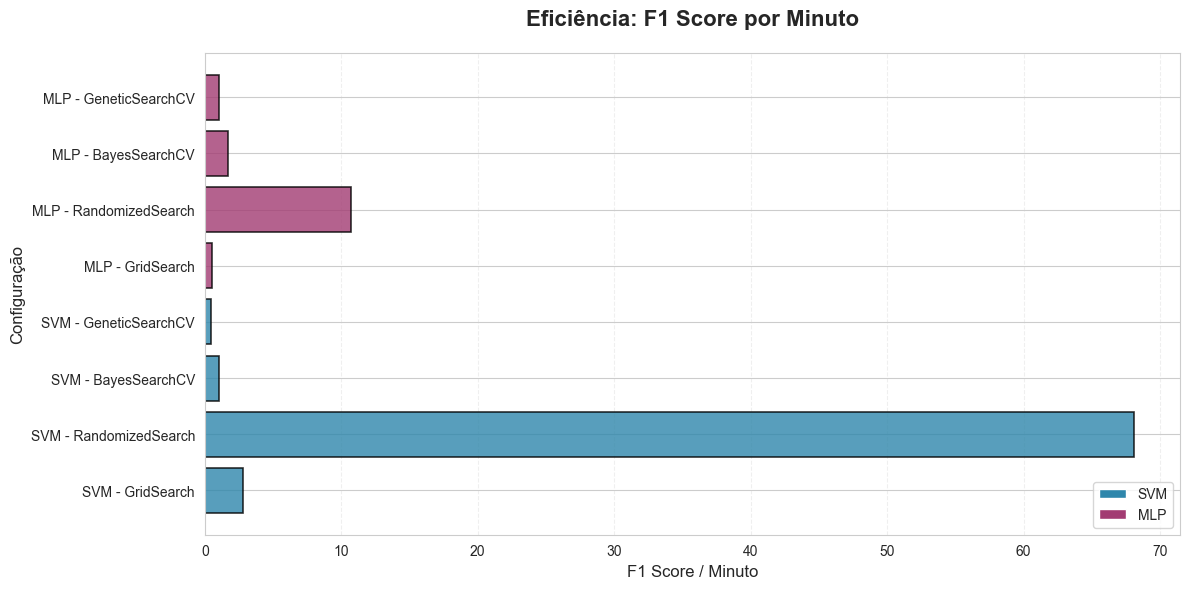

Todas as visualizações foram salvas na pasta 'figuras/':
  - figuras/fig1_f1_cv_desvio_padrao.png
  - figuras/fig2_cv_vs_teste.png
  - figuras/fig3_boxplot_estrategias.png
  - figuras/fig4_tempo_execucao.png
  - figuras/fig5_eficiencia.png


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
os.makedirs('figuras', exist_ok=True)

# 1. F1 Score (CV): Média ± Desvio Padrão
fig1, ax1 = plt.subplots(figsize=(12, 6))
positions = range(len(df_results))
colors_box = ['#2E86AB' if model == 'SVM' else '#A23B72' for model in df_results['model']]

ax1.bar(positions, df_results['cv_f1_mean'], yerr=df_results['cv_f1_std'], 
        capsize=5, color=colors_box, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title('F1 Score (CV): Média ± Desvio Padrão', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Configuração (Modelo - Estratégia)', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_xticks(positions)
ax1.set_xticklabels([f"{row['model']}\n{row['strategy']}" for _, row in df_results.iterrows()], 
                      rotation=45, ha='right', fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=df_results['cv_f1_mean'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.5, label=f'Média Geral: {df_results["cv_f1_mean"].mean():.4f}')

legend_elements = [Patch(facecolor='#2E86AB', label='SVM'),
                   Patch(facecolor='#A23B72', label='MLP')]
ax1.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('figuras/fig1_f1_cv_desvio_padrao.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Comparação CV vs Teste com Barras de Erro
fig2, ax2 = plt.subplots(figsize=(14, 6))
x = np.arange(len(df_results))
width = 0.35

# Cores diferentes para SVM e MLP
colors_cv = ['#2E86AB' if model == 'SVM' else '#A23B72' for model in df_results['model']]
colors_test = ['#1a5f7a' if model == 'SVM' else '#7d1f54' for model in df_results['model']]

bars1 = ax2.bar(x - width/2, df_results['cv_f1_mean'], width, 
                yerr=df_results['cv_f1_std'], capsize=5,
                label='CV F1 (Média ± DP)', alpha=0.7, color=colors_cv, 
                edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x + width/2, df_results['test_f1'], width, 
                label='Teste F1', alpha=0.9, color=colors_test,
                edgecolor='black', linewidth=1.2)

ax2.set_title('Comparação: F1 (CV com Desvio Padrão) vs F1 (Teste)', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Configuração', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['model']}\n{row['strategy']}" for _, row in df_results.iterrows()], rotation=45, ha='right', fontsize=9)

# Legenda customizada
legend_elements = [
    Patch(facecolor='#2E86AB', label='SVM', alpha=0.8),
    Patch(facecolor='#A23B72', label='MLP', alpha=0.8)
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figuras/fig2_cv_vs_teste.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Box Plot - Comparação por Estratégia
fig3, ax3 = plt.subplots(figsize=(12, 6))
strategies = df_results['strategy'].unique()
strategy_data = [df_results[df_results['strategy'] == s]['cv_f1_mean'].values for s in strategies]

bp = ax3.boxplot(strategy_data, labels=strategies, patch_artist=True,
                 showmeans=True, meanline=True,
                 boxprops=dict(alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 meanprops=dict(color='green', linewidth=2, linestyle='--'),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

colors_strategy = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp['boxes'], colors_strategy):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_title('Distribuição de F1 Score (CV) por Estratégia', fontsize=16, fontweight='bold', pad=20)
ax3.set_ylabel('F1 Score', fontsize=12)
ax3.set_xlabel('Estratégia de Otimização', fontsize=12)
ax3.set_xticklabels(strategies, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figuras/fig3_boxplot_estrategias.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Tempo de Execução
fig4, ax4 = plt.subplots(figsize=(12, 6))
df_pivot_time = df_results.pivot(index='strategy', columns='model', values='time_s')
df_pivot_time.plot(kind='bar', ax=ax4, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black', linewidth=1.2)
ax4.set_title('Tempo de Execução por Modelo e Estratégia', fontsize=16, fontweight='bold', pad=20)
ax4.set_xlabel('Estratégia de Otimização', fontsize=12)
ax4.set_ylabel('Tempo (segundos)', fontsize=12)
ax4.legend(title='Modelo', fontsize=11)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('figuras/fig4_tempo_execucao.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Eficiência (F1/Tempo)
fig5, ax5 = plt.subplots(figsize=(12, 6))
colors_eff = ['#2E86AB' if model == 'SVM' else '#A23B72' for model in df_results['model']]
bars = ax5.barh(range(len(df_results)), df_results['efficiency_score'], color=colors_eff, alpha=0.8, edgecolor='black', linewidth=1.2)
ax5.set_title('Eficiência: F1 Score por Minuto', fontsize=16, fontweight='bold', pad=20)
ax5.set_xlabel('F1 Score / Minuto', fontsize=12)
ax5.set_ylabel('Configuração', fontsize=12)
ax5.set_yticks(range(len(df_results)))
ax5.set_yticklabels([f"{row['model']} - {row['strategy']}" for _, row in df_results.iterrows()], fontsize=10)
ax5.grid(axis='x', alpha=0.3, linestyle='--')

legend_elements = [Patch(facecolor='#2E86AB', label='SVM'), Patch(facecolor='#A23B72', label='MLP')]
ax5.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('figuras/fig5_eficiencia.png', dpi=300, bbox_inches='tight')
plt.show()

print("Todas as visualizações foram salvas na pasta 'figuras/':")
print("  - figuras/fig1_f1_cv_desvio_padrao.png")
print("  - figuras/fig2_cv_vs_teste.png")
print("  - figuras/fig3_boxplot_estrategias.png")
print("  - figuras/fig4_tempo_execucao.png")
print("  - figuras/fig5_eficiencia.png")

### Resumo Executivo para o Relatório

In [112]:


# Resumo Executivo
output_md = "# RESUMO EXECUTIVO PARA O RELATÓRIO\n\n"

# Melhor configuração geral
best_overall = df_results.loc[df_results['test_f1'].idxmax()]

output_md += "## PRINCIPAIS RESULTADOS\n\n"
output_md += "### 1. MELHOR CONFIGURAÇÃO GERAL\n\n"
output_md += f"- **Modelo:** {best_overall['model']}\n"
output_md += f"- **Estratégia:** {best_overall['strategy']}\n"
output_md += f"- **F1 Score (Teste):** {best_overall['test_f1']:.4f}\n"
output_md += f"- **F1 Score (CV):** {best_overall['cv_f1_mean']:.4f} ± {best_overall['cv_f1_std']:.4f}\n"
output_md += f"- **Acurácia (Teste):** {best_overall['test_accuracy']:.4f}\n"
output_md += f"- **ROC-AUC (Teste):** {best_overall['test_roc_auc']:.4f}\n"
output_md += f"- **Tempo de execução:** {best_overall['time_s']:.2f}s\n\n"

# Melhor custo-benefício
best_efficiency = df_results.loc[df_results['efficiency_score'].idxmax()]
output_md += "### 2. MELHOR CUSTO-BENEFÍCIO\n\n"
output_md += f"- **Configuração:** {best_efficiency['model']} - {best_efficiency['strategy']}\n"
output_md += f"- **F1 (Teste):** {best_efficiency['test_f1']:.4f}\n"
output_md += f"- **Tempo:** {best_efficiency['time_s']:.2f}s\n\n"

# Comparação de modelos
output_md += "### 3. COMPARAÇÃO ENTRE MODELOS\n\n"
for model in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model]
    best_model_config = model_data.loc[model_data['test_f1'].idxmax()]
    output_md += f"#### {model}\n\n"
    output_md += f"- Melhor estratégia: {best_model_config['strategy']}\n"
    output_md += f"- F1 máximo: {model_data['test_f1'].max():.4f}\n"
    output_md += f"- F1 mínimo: {model_data['test_f1'].min():.4f}\n"
    output_md += f"- Variação: {(model_data['test_f1'].max() - model_data['test_f1'].min()):.4f}\n\n"

output_md += "### 4. COMPARAÇÃO ENTRE ESTRATÉGIAS\n\n"
strategy_comparison = df_results.groupby('strategy').agg({
    'test_f1': ['mean', 'std'],
    'time_s': 'mean'
}).round(4)

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    output_md += f"#### {strategy}\n\n"
    output_md += f"- F1 médio: {strategy_data['test_f1'].mean():.4f} ± {strategy_data['test_f1'].std():.4f}\n"
    output_md += f"- Tempo médio: {strategy_data['time_s'].mean():.2f}s\n\n"

output_md += "### 5. OBSERVAÇÕES IMPORTANTES\n\n"

overfit_count = len(df_results[df_results['gap_f1'] > 0.05])
if overfit_count > 0:
    output_md += f"- {overfit_count} configuração(ões) com possível overfitting\n"
else:
    output_md += f"- Não há casos significativos de overfitting\n"

most_stable = df_results.loc[df_results['cv_coefficient_variation'].idxmin()]
output_md += f"- Configuração mais estável: {most_stable['model']} - {most_stable['strategy']}\n"
output_md += f"  (Coeficiente de Variação = {most_stable['cv_coefficient_variation']:.2f}%)\n\n"

output_md += "### 6. ANÁLISE DOS HIPERPARÂMETROS\n\n"
try:
    params = ast.literal_eval(row['best_params'])
    if 'clf__class_weight' in params:
        output_md += f"- {row['strategy']}: {params['clf__class_weight']} (F1={row['test_f1']:.4f})\n"
except:
    pass

output_md += "\n#### MLP - early_stopping\n\n"
for _, row in df_results[df_results['model'] == 'MLP'].iterrows():
    try:
        params = ast.literal_eval(row['best_params'])
        if 'clf__early_stopping' in params:
            output_md += f"- {row['strategy']}: {params['clf__early_stopping']} (F1={row['test_f1']:.4f})\n"
    except:
        pass

display(Markdown(output_md))

# RESUMO EXECUTIVO PARA O RELATÓRIO

## PRINCIPAIS RESULTADOS

### 1. MELHOR CONFIGURAÇÃO GERAL

- **Modelo:** MLP
- **Estratégia:** GridSearch
- **F1 Score (Teste):** 0.6380
- **F1 Score (CV):** 0.6678 ± 0.0759
- **Acurácia (Teste):** 0.7446
- **ROC-AUC (Teste):** 0.7981
- **Tempo de execução:** 76.08s

### 2. MELHOR CUSTO-BENEFÍCIO

- **Configuração:** SVM - RandomizedSearch
- **F1 (Teste):** 0.6180
- **Tempo:** 0.54s

### 3. COMPARAÇÃO ENTRE MODELOS

#### SVM

- Melhor estratégia: GridSearch
- F1 máximo: 0.6180
- F1 mínimo: 0.6145
- Variação: 0.0035

#### MLP

- Melhor estratégia: GridSearch
- F1 máximo: 0.6380
- F1 mínimo: 0.5444
- Variação: 0.0937

### 4. COMPARAÇÃO ENTRE ESTRATÉGIAS

#### GridSearch

- F1 médio: 0.6280 ± 0.0142
- Tempo médio: 44.67s

#### RandomizedSearch

- F1 médio: 0.5963 ± 0.0306
- Tempo médio: 1.88s

#### BayesSearchCV

- F1 médio: 0.5795 ± 0.0496
- Tempo médio: 26.99s

#### GeneticSearchCV

- F1 médio: 0.5834 ± 0.0477
- Tempo médio: 58.39s

### 5. OBSERVAÇÕES IMPORTANTES

- 5 configuração(ões) com possível overfitting
- Configuração mais estável: MLP - RandomizedSearch
  (Coeficiente de Variação = 8.80%)

### 6. ANÁLISE DOS HIPERPARÂMETROS


#### MLP - early_stopping

- GridSearch: True (F1=0.6380)
